# `20181104a` - Phantom and probes - Processing

In [1]:
#!/usr/bin/python
import spidev
import time
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import json
import time
from pyUn0 import *
%matplotlib inline
import os
from scipy.signal import hilbert, resample
import cv2

Not loading RPi.GPIO as not on RPi


Data acquired


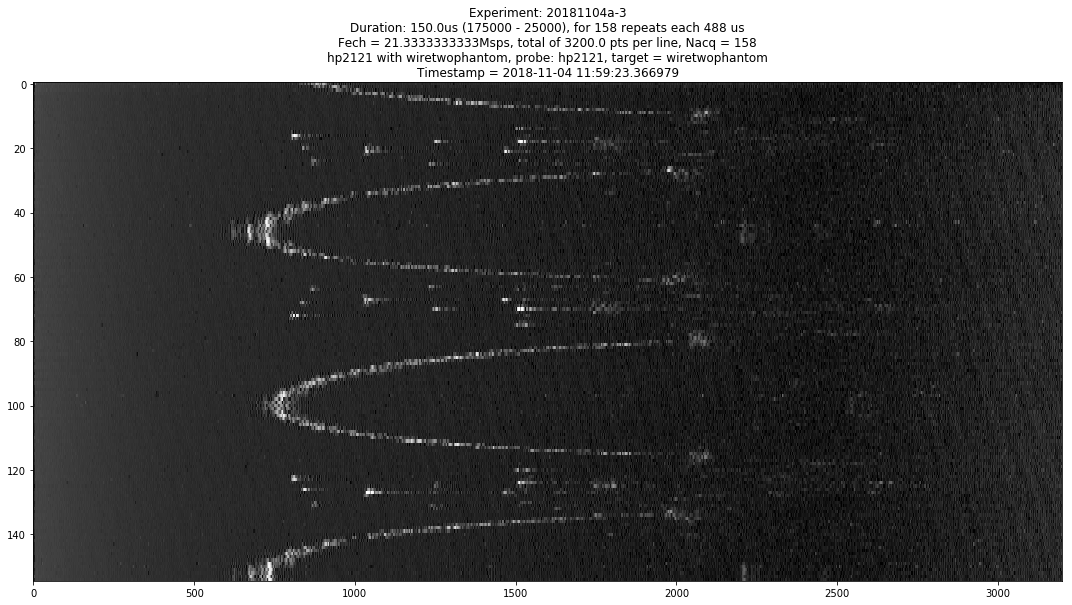

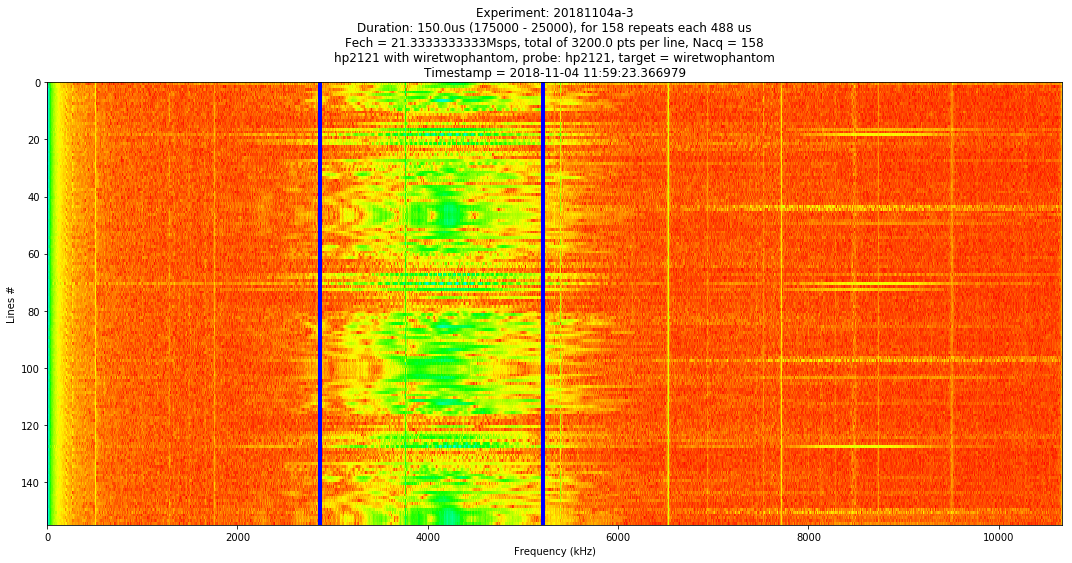

In [2]:
for MyDataFile in os.listdir("data/"):
    if MyDataFile.endswith("3.json"):
        x = us_json()
        x.fPiezo = 4.1
        x.JSONprocessing("data/"+MyDataFile)
        CleanImage = x.mk2DArray()
        S = x.mkSpectrum(CleanImage)
        F,FFTFil = x.mkFiltered(CleanImage)

## Cleaning the signal

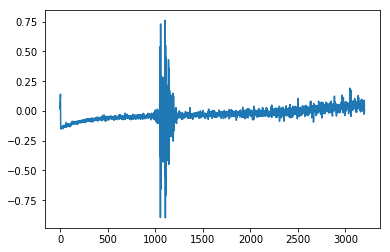

In [16]:
line = CleanImage[110]
plt.plot(line)
plt.show()

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


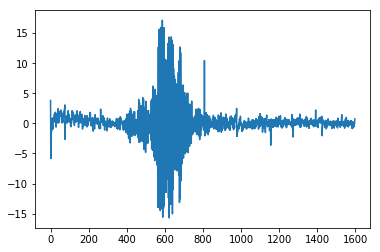

In [4]:
FFT = np.fft.fft(line)
plt.plot(FFT[1:len(FFT)/2])
plt.show()

In [5]:
FFT = np.fft.fft(line)
for k in range (len(FFT)/2 +1):
    if k < 400 or k > 800:
        FFT[k] = 0
        FFT[-k] = 0

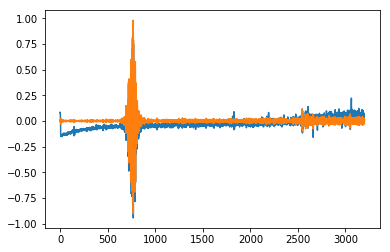

In [6]:
IFFT = np.fft.ifft(FFT)
plt.plot(line)
plt.plot(IFFT)
plt.show()

In [17]:
Cleaned = [] 
CleanHilbert = []
for p in range (len(CleanImage)):
    FFT = np.fft.fft(CleanImage[p])
    for k in range (len(FFT)/2 +1):
        if (k < 400 or k > 800):
            FFT[k] = 0
            FFT[-k] = 0
    F =np.real(np.fft.ifft(FFT))
    Cleaned.append(F)
    CleanHilbert.append(np.abs(signal.hilbert(F)))

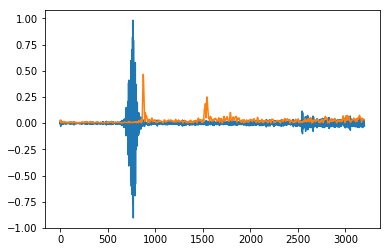

In [18]:
plt.plot(Cleaned[100])
plt.plot(CleanHilbert[130])
plt.show()

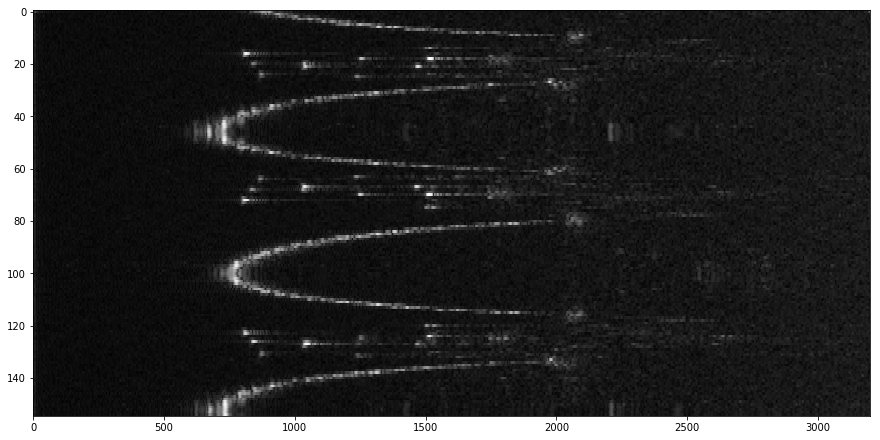

In [19]:
imSize = np.shape(CleanHilbert)
plt.figure(figsize = (15,10))
plt.imshow(np.sqrt(np.abs(CleanHilbert)), cmap='gray', aspect=0.5*(imSize[1]/imSize[0]), interpolation='nearest')
plt.show() 

## Image 1

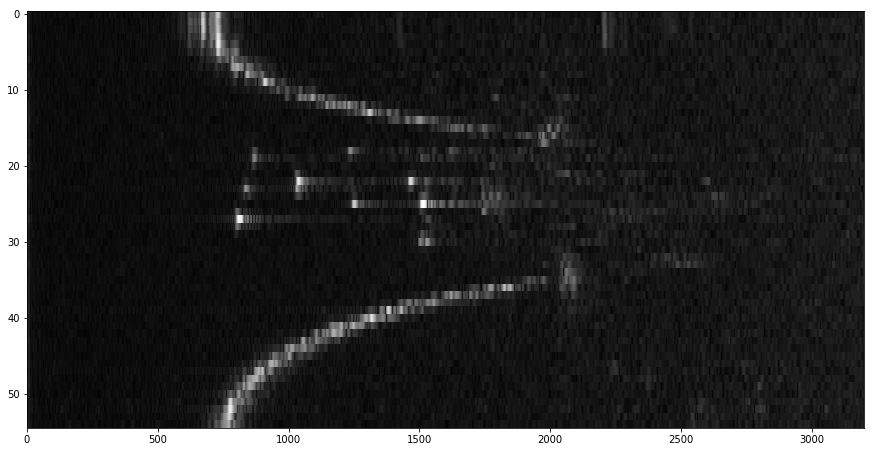

In [21]:
imSize = np.shape(CleanHilbert[45:100])
plt.figure(figsize = (15,10))
plt.imshow(np.sqrt(np.abs(CleanHilbert[45:100])), cmap='gray', aspect=0.5*(imSize[1]/imSize[0]), interpolation='nearest')
plt.show() 

## Image 2

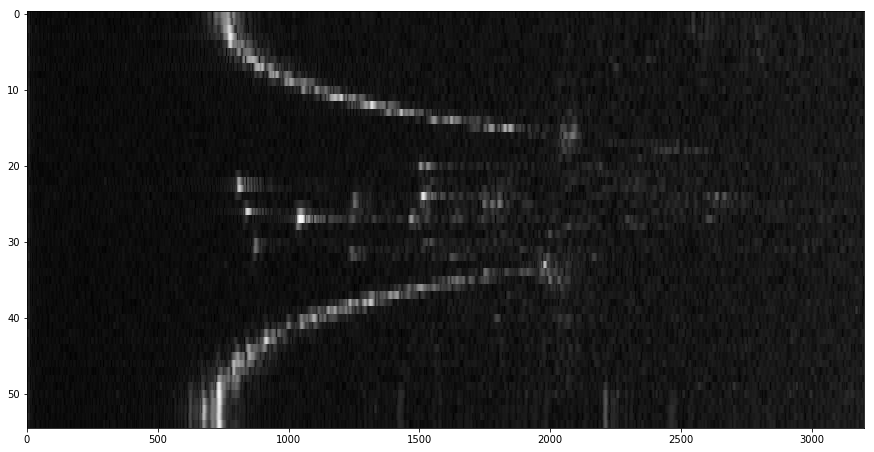

In [22]:
imSize = np.shape(CleanHilbert[100:])
plt.figure(figsize = (15,10))
plt.imshow(np.sqrt(np.abs(CleanHilbert[100:])), cmap='gray', aspect=0.5*(imSize[1]/imSize[0]), interpolation='nearest')
plt.show() 

In [42]:
25.0*64/3.0
a = np.asarray(CleanHilbert[45:100])
b = np.zeros((55,533+70)) #70 for the piezo offset
np.shape(a),np.shape(b)

((55, 3200), (55, 603))

In [43]:
c = np.c_[b,a]

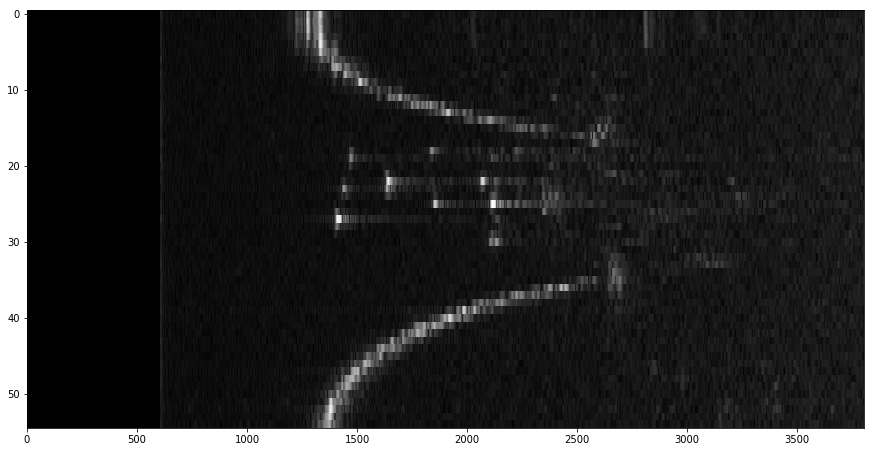

In [44]:
imSize = np.shape(c)
plt.figure(figsize = (15,10))
plt.imshow(np.sqrt(np.abs(c)), cmap='gray', aspect=0.5*(imSize[1]/imSize[0]), interpolation='nearest')
plt.show() 

# SCan COnversion

In [45]:
HMatrixCld = c
n,l = np.shape(HMatrixCld)
print n,l

55 3803


In [46]:
im_in = np.asarray(HMatrixCld[0:150,:])

im_in.shape[0],im_in.shape[1]



(55, 3803)

maxRadius = 3803 pixels
35.0140874802 rows per radian
theta: [2.35619449019, 3.92699081699] radians
Padding 41 above and 41 below
CPU times: user 2.54 s, sys: 1.26 s, total: 3.8 s
Wall time: 2.67 s


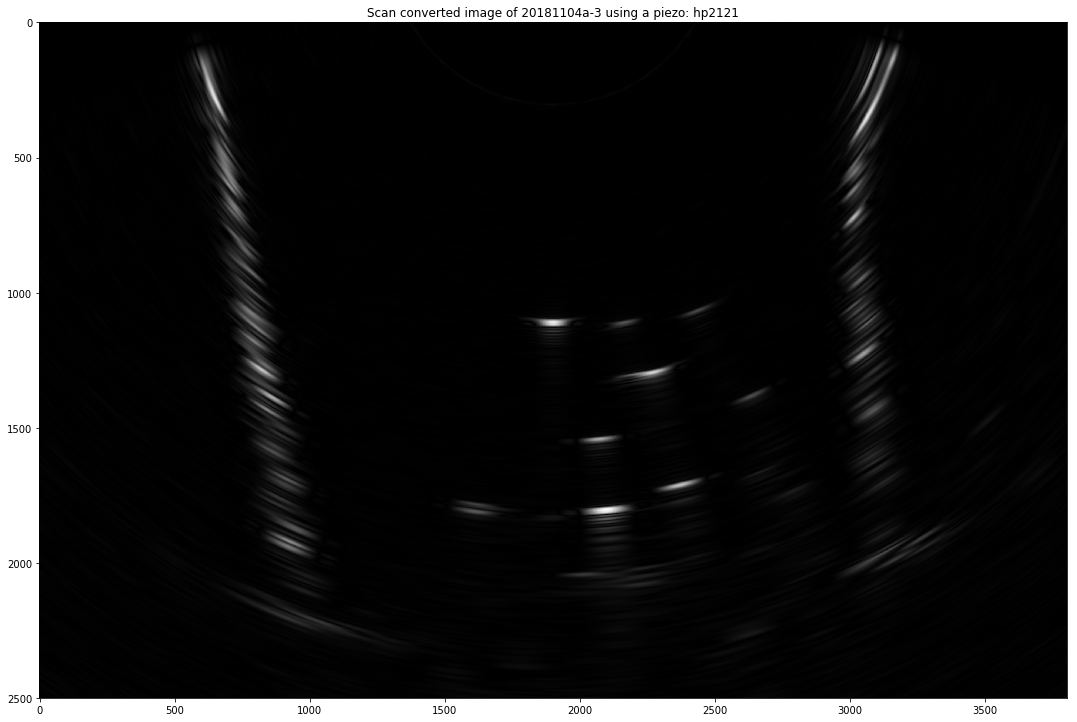

In [48]:
%%time

maxRadius = im_in.shape[1]
rows = im_in.shape[1]
print("maxRadius = {} pixels".format(maxRadius))

angle_range = np.pi/2 # range of angle swept by transducer (radians)
theta_scale_factor = im_in.shape[0] / angle_range # rows per radian
print("{} rows per radian".format(theta_scale_factor))
theta_min = 3/2*np.pi - angle_range/2
theta_max = 3/2*np.pi + angle_range/2
print("theta: [{}, {}] radians".format(theta_min, theta_max))

# pad the image
pad_below = int(0.5* theta_min * theta_scale_factor) # how many rows to pad below theta_min
pad_above = int(0.5* (2*np.pi - theta_max) * theta_scale_factor) # how mahy rows to pad above theta_max
print("Padding {} above and {} below".format(pad_above, pad_below))
im_below = np.zeros((pad_below, maxRadius), dtype='uint16')
im_above = np.zeros((pad_above, maxRadius), dtype='uint16')

padded_image = np.vstack((im_above, im_in, im_below))
# scale image
scaled_image = cv2.resize(padded_image, (2*maxRadius, maxRadius), interpolation=cv2.INTER_CUBIC)
#scaled_image = padded_image
# transform image
center = (rows-1000, rows/2)
maxRadius = rows
flags = cv2.WARP_INVERSE_MAP
dst = cv2.linearPolar(scaled_image, center, maxRadius, flags)
plt.figure(figsize = (15,15))
Title = "Scan converted image of "+x.iD + "-"+ str(x.N)+" using a piezo: "+x.piezo
plt.title( Title )
plt.tight_layout()
FileName = "images/SC_"+x.iD+"-"+str(x.N)+"-fft.jpg"
plt.imshow(np.flipud(np.transpose((np.abs(dst)))[:2500,:]), cmap='gray')
plt.savefig(FileName)
TagImage(FileName,"matty,hp2121,"+x.piezo,x.iD,"SC",Title)